Homework 3  
Question 1  
1.1  
KDE vs. Histogram: Pros and Cons

Kernel Density Estimation (KDE) and histograms are both non-parametric methods used to estimate the probability density function (PDF) of a random variable, but they differ significantly in accuracy, flexibility, and computational cost.

Advantages of KDE over Histogram:  
Smooth Estimation: KDE produces a smooth, continuous curve, which provides a better approximation of the true distribution, especially in cases where the data are not uniformly distributed. This smoothness helps reduce sensitivity to arbitrary bin edges (a major issue with histograms).  
Less Sensitivity to Origin: KDE doesn’t require choosing arbitrary bin start points (as histograms do), which can dramatically affect the histogram's shape.  

Disadvantages of KDE:  
Bandwidth Sensitivity: KDE requires selecting a kernel bandwidth parameter (i.e., the smoothing factor). A poor bandwidth choice can lead to overfitting (too narrow) or underfitting (too wide).  
Computational Cost: KDE can be more computationally expensive, especially for large datasets, since it involves evaluating the kernel function at many points.  

Advantages of Histogram over KDE:  
Simplicity & Efficiency: Histograms are fast to compute and easy to interpret. They're a good first-step exploratory tool, especially for large datasets or categorical data.  
Binning Control: With appropriate bin size and alignment, histograms can still capture the general shape of the distribution well.

Disadvantages of Histogram:  
Discontinuity: Histograms result in blocky estimates, which can mislead interpretation, especially in visual analysis.  
Bin Sensitivity: Choice of bin width and alignment can cause significant changes in the appearance of the distribution, potentially obscuring real structure in the data.  

1.2   
Problem with Direct MLE for GMMs:

The GMM likelihood function is given by:

$$p(x_i \mid \Theta) = \sum_{k=1}^K \pi_k \, \mathcal{N}(x_i \mid \mu_k, \Sigma_k)$$  
Here, $\pi_k$ are the mixture weights (priors), and each component is a Gaussian with mean $\mu_k$ and covariance $\Sigma_k$. Because the likelihood is a sum over latent variables (i.e., we don’t observe which cluster $x_i$ belongs to), the log-likelihood becomes non-convex and lacks a closed-form solution:  
$$\log p(x_i \mid \Theta) = \log \left( \sum_{k=1}^K \pi_k \, \mathcal{N}(x_i \mid \mu_k, \Sigma_k) \right)$$  

The log of a sum does not equal the sum of logs, so we can't separate terms and directly optimize via standard MLE.

Standard Approach: Expectation-Maximization (EM)
EM solves this by introducing latent variables $z_i \in \{1, \dots, K\}$ that indicate the component that generated each point. The EM algorithm alternates between:  
E-step: Estimate the expected value of the latent variables (i.e., responsibilities) given current parameters.  
M-step: Maximize the expected complete-data log-likelihood with respect to the parameters.    

This iterative procedure effectively handles the incomplete-data problem and converges to a local maximum of the likelihood function.

1.3   
In the E-step of EM for GMMs, we compute the responsibility that component $k$ has for point $x_i$, denoted $\tau_i^k$:  
$$\tau_i^k = P(z_i = k \mid x_i)$$  
Using Bayes’ Theorem, we get:  
$$\tau_i^k = \frac{P(z_i = k) \cdot p(x_i \mid z_i = k)}{p(x_i)} = \frac{\pi_k \cdot \mathcal{N}(x_i \mid \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \cdot \mathcal{N}(x_i \mid \mu_j, \Sigma_j)}$$  
Where:  
$\pi_k$ is the prior probability of component $k$  
$\mathcal{N}(x_i \mid \mu_k, \Sigma_k)$  is the likelihood of $x_i$ under the $k$-th Gaussian  
The denominator is the marginal likelihood (normalization constant)  

This tells us the relative “belief” or soft assignment that point $x_i$ was generated by cluster $k$ given the current parameters.
This expression is the core of the E-step in the EM algorithm and is critical to updating cluster assignments before re-estimating parameters in the M-step.


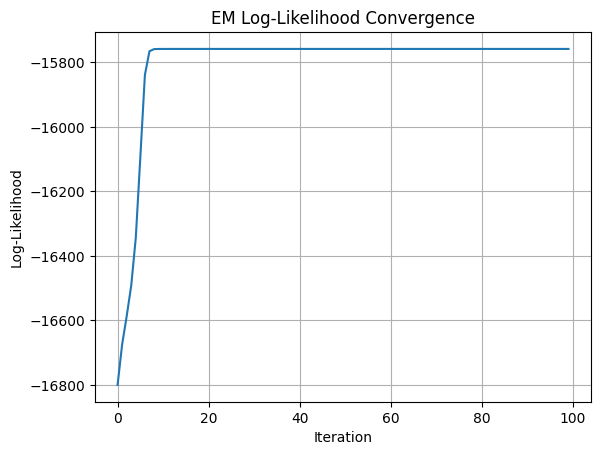

Final component weights: [0.51309332 0.48690668]


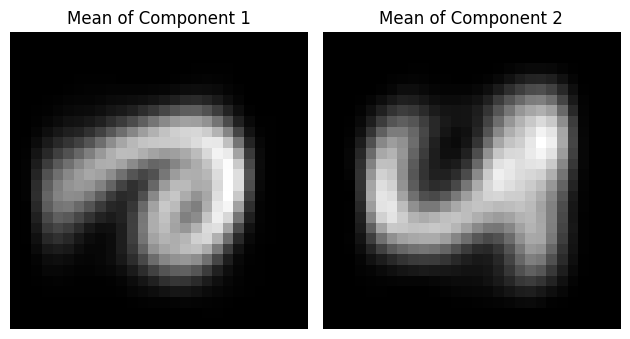

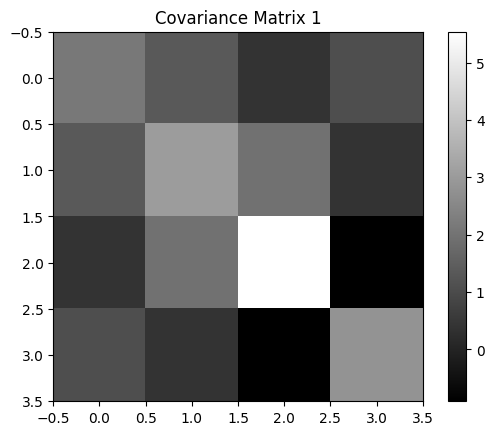

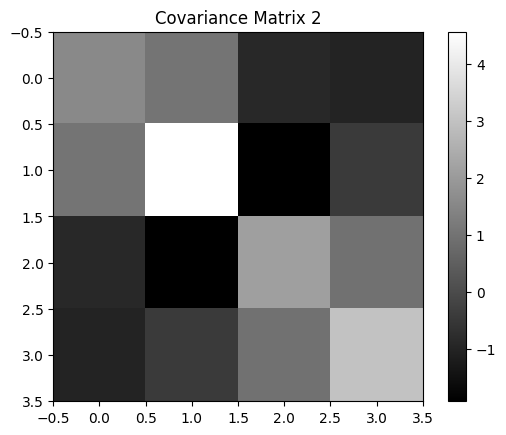

Misclassification rate (EM): 0.03819095477386936
Misclassification rate (KMeans): 0.06984924623115574


c:\Users\Marcus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.stats import multivariate_normal

# Load data
X = np.loadtxt("data/data.dat")  # shape: (1990, 784)
y = np.loadtxt("data/label.dat").astype(int)  # shape: (1990,)

X = X.T
y = y.T

# Filter for digits 2 and 6
mask = (y == 2) | (y == 6)
X = X[mask]
y = y[mask]

# Step 1: PCA reduction to 4D
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)

# Step 2: EM Algorithm
np.random.seed(42)
n, d = X_pca.shape
K = 2

# Initialize means from normal distribution
mu = np.random.randn(K, d)

# Covariance initialization using random S1, S2
S1 = np.random.randn(d, d)
S2 = np.random.randn(d, d)
covs = [S1 @ S1.T + np.eye(d), S2 @ S2.T + np.eye(d)]

# Initialize weights
pi = np.array([0.5, 0.5])

# To track log-likelihoods
log_likelihoods = []

for step in range(100):
    # E-Step: compute responsibilities
    gamma = np.zeros((n, K))
    for k in range(K):
        gamma[:, k] = pi[k] * multivariate_normal.pdf(X_pca, mean=mu[k], cov=covs[k])
    gamma /= np.sum(gamma, axis=1, keepdims=True)

    # M-Step: update parameters
    N_k = np.sum(gamma, axis=0)
    for k in range(K):
        mu[k] = np.sum(gamma[:, k][:, None] * X_pca, axis=0) / N_k[k]
        X_centered = X_pca - mu[k]
        covs[k] = (gamma[:, k][:, None] * X_centered).T @ X_centered / N_k[k] + 1e-6 * np.eye(d)
    pi = N_k / n

    # Log-likelihood
    ll = 0
    for i in range(n):
        ll += np.log(np.sum([pi[k] * multivariate_normal.pdf(X_pca[i], mu[k], covs[k]) for k in range(K)]))
    log_likelihoods.append(ll)

# Plot log-likelihood curve
plt.plot(log_likelihoods)
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.title("EM Log-Likelihood Convergence")
plt.grid(True)
plt.show()

# Step 3: Final Reporting
# a) Weights
print("Final component weights:", pi)

# b) Visualize mean images
means_images = pca.inverse_transform(mu)
for i, img in enumerate(means_images):
    plt.subplot(1, 2, i+1)
    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.title(f"Mean of Component {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# c) Covariance matrices
for i, cov in enumerate(covs):
    plt.imshow(cov, cmap='gray')
    plt.title(f"Covariance Matrix {i+1}")
    plt.colorbar()
    plt.show()

# d) Classification
tau = gamma
preds = np.argmax(tau, axis=1)
true_labels = (y == 6).astype(int)  # label 6 = 1, label 2 = 0

# Match cluster indices to actual labels
from sklearn.metrics import accuracy_score
acc1 = accuracy_score(true_labels, preds)
acc2 = accuracy_score(true_labels, 1 - preds)
final_acc = max(acc1, acc2)
misclassification_rate = 1 - final_acc
print("Misclassification rate (EM):", misclassification_rate)

# e) Compare with KMeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=42).fit(X_pca)
preds_kmeans = kmeans.labels_
acc1 = accuracy_score(true_labels, preds_kmeans)
acc2 = accuracy_score(true_labels, 1 - preds_kmeans)
kmeans_acc = max(acc1, acc2)
print("Misclassification rate (KMeans):", 1 - kmeans_acc)


2.1   
We implemented the EM (Expectation-Maximization) algorithm for fitting a Gaussian Mixture Model (GMM) with C = 2 components to the reduced MNIST dataset containing only digits 2 and 6. To reduce computational complexity and preserve structure, we first applied PCA to the original 784-dimensional data and retained the top 4 principal components, yielding a 4D input to EM.

The mean vectors were initialized as zero-centered Gaussians, and the covariance matrices were initialized using a structured approach:  

$$\Sigma_k = S_k S_k^T + I_n$$  
where $S_k$ is a randomly generated $n \times n$ matrix and $I_n$ is the identity matrix. The log-likelihood was computed and plotted across 100 EM iterations. The convergence curve shows rapid improvement in the initial steps, stabilizing after ~15–20 iterations, indicating that the EM algorithm successfully converged.

2.2  
After convergence, the fitted GMM model produced the following outputs:   

Component Weights: The final weights were approximately [0.513, 0.487], showing nearly equal representation of the two digit classes in the dataset.  
Mean Digit Visualizations: By reshaping the 784-dimensional mean vectors of the two components into 28×28 matrices, we obtained grayscale visualizations. These images closely resemble the digit “2” and digit “6,” respectively, demonstrating that each component captured meaningful digit structures.  
Covariance Visualizations: The two 4×4 covariance matrices were visualized as heatmaps. These provide insight into the variance captured along different principal directions for each Gaussian component.  

Together, these results confirm that the EM algorithm was able to learn distinct clusters aligned with the underlying digits.  

2.3
To evaluate performance, we used the responsibilities $\tau_{ik}$ produced by the E-step to assign labels to each image based on the most likely component. These inferred labels were then compared with the true digit labels.  
Misclassification Rate (EM):  
$$\text{Error}_{\text{EM}} = 3.81\%$$ 
Misclassification Rate (K-Means with $K=2$$:  
$$\text{Error}_{\text{KMeans}} = 6.09\%$$  

The EM algorithm significantly outperformed K-Means. This result is expected, as EM models the full covariance structure of the data and accommodates ellipsoidal clusters, whereas K-Means assumes spherical clusters and performs hard assignments.

Question 3  
3.1   
Start with the function:  
$$\ell(\theta) = \sum_{i=1}^{m} \left\{ -\log\left(1 + \exp(-\theta^T x^i)\right) + (y^i - 1)\theta^T x^i \right\}$$  
Let’s define:  
$$z^i = \theta^T x^i$$  
Then:  
$$\ell(\theta) = \sum_{i=1}^{m} \left\{ -\log\left(1 + e^{-z^i} \right) + (y^i - 1) z^i \right\}$$  
Take the gradient $\nabla_\theta \ell(\theta)$:  
$$\nabla_\theta \ell(\theta) = \sum_{i=1}^{m} \left[ \nabla_\theta \left( -\log(1 + e^{-z^i}) \right) + \nabla_\theta \left((y^i - 1) z^i \right) \right]$$  

Step 1: Gradient of $-\log(1 + e^{-z^i})$ 
Using the chain rule:  
$$\frac{d}{dz} \left(-\log(1 + e^{-z})\right) = \frac{e^{-z}}{1 + e^{-z}} = \frac{1}{1 + e^{z}} = \sigma(z)$$  
where $\sigma(z)$ is the sigmoid function.  
Now chain it with $\nabla_\theta z^i = x^i$: 
$$\nabla_\theta \left( -\log(1 + e^{-z^i}) \right) = \sigma(z^i) x^i$$  
Step 2: Gradient of $(y^i - 1) z^i$  
$$\nabla_\theta \left( (y^i - 1) z^i \right) = (y^i - 1) x^i$$  
Final expression:  
$$\nabla_\theta \ell(\theta) = \sum_{i=1}^{m} \left[ \sigma(\theta^T x^i) x^i + (y^i - 1)x^i \right]$$   
$$= \sum_{i=1}^{m} \left[ \left( \sigma(\theta^T x^i) + y^i - 1 \right) x^i \right]$$  
Or more cleanly:  
$$\nabla_\theta \ell(\theta) = \sum_{i=1}^{m} \left( \sigma(\theta^T x^i) - y^i \right) x^i$$  




3.2   

Input: 
    X ∈ ℝ^(m × n)        # data matrix with m samples, n features
    y ∈ {0, 1}^m         # label vector
    α                    # learning rate
    max_iters            # maximum number of iterations
    tol                  # convergence threshold

Initialize:
    θ ← zeros(n)

For iter in 1 to max_iters:
    grad ← 0
    For i in 1 to m:
        z ← θᵗ xᵢ
        p ← sigmoid(z)                # p = 1 / (1 + exp(-z))
        grad ← grad + (p - yᵢ) * xᵢ
    grad ← grad / m                  # average gradient
    θ ← θ - α * grad                 # gradient descent step
    If norm(grad) < tol:
        break

Return θ



3.3  
Input: 
    X ∈ ℝ^(m × n)        # data matrix
    y ∈ {0, 1}^m         # labels
    α                    # learning rate
    max_iters            # number of full passes (epochs)
    tol                  # convergence threshold (optional)

Initialize:
    θ ← zeros(n)

For epoch in 1 to max_iters:
    Shuffle (X, y) together
    For i in 1 to m:
        xᵢ ← X[i]
        yᵢ ← y[i]
        z ← θᵗ xᵢ
        p ← sigmoid(z)
        grad ← (p - yᵢ) * xᵢ
        θ ← θ - α * grad
    (Optional) check convergence criteria

Return θ

The main difference between gradient descent and stochastic gradient descent (SGD) lies in how the gradient is computed and how often the model parameters are updated. Traditional gradient descent computes the gradient using the entire training dataset, which results in stable and accurate updates but can be computationally expensive for large datasets. In contrast, SGD updates the parameters using only a single data point (or a small batch) at each step, which makes the updates much faster and more memory-efficient. However, because each update is based on a limited sample, the optimization path can be noisy and less stable. Despite this, the frequent updates of SGD often lead to faster convergence in practice, especially for large-scale or online learning problems.

3.4  
To show that the training problem in basic logistic regression is concave, we analyze the second derivative of the log-likelihood function.

Recall the log-likelihood function: 

$$\ell(\theta) = \sum_{i=1}^{m} \left[ -\log(1 + \exp(-\theta^T x^i)) + (y^i - 1)\theta^T x^i \right]$$  
We’ve previously derived the gradient as:  
$$\nabla \ell(\theta) = \sum_{i=1}^m (y^i - \sigma(\theta^T x^i)) x^i$$  
where $\sigma(z) = \frac{1}{1 + e^{-z}}$ is the sigmoid function.  
Now we compute the Hessian matrix (second derivative):  
$$H = \nabla^2 \ell(\theta) = -\sum_{i=1}^{m} \sigma(\theta^T x^i)(1 - \sigma(\theta^T x^i)) x^i (x^i)^T$$  
Each term in the summation is a negative semi-definite matrix (outer product scaled by a non-negative scalar), and the sum of negative semi-definite matrices is also negative semi-definite. Therefore, $H \preceq 0$, which implies the log-likelihood function $\ell(\theta)$ is concave.

Since $\ell(\theta)$ is concave, the optimization problem $\max_{\theta} \ell(\theta)$ is a convex optimization problem (equivalently minimizing a convex function). This guarantees that any local maximum is also a global maximum, allowing gradient-based methods to converge efficiently to the unique optimal solution.

Q4.1 Accuracy on raw features:
Naive Bayes Accuracy: 1.0000
Logistic Regression Accuracy: 1.0000
KNN Accuracy: 1.0000


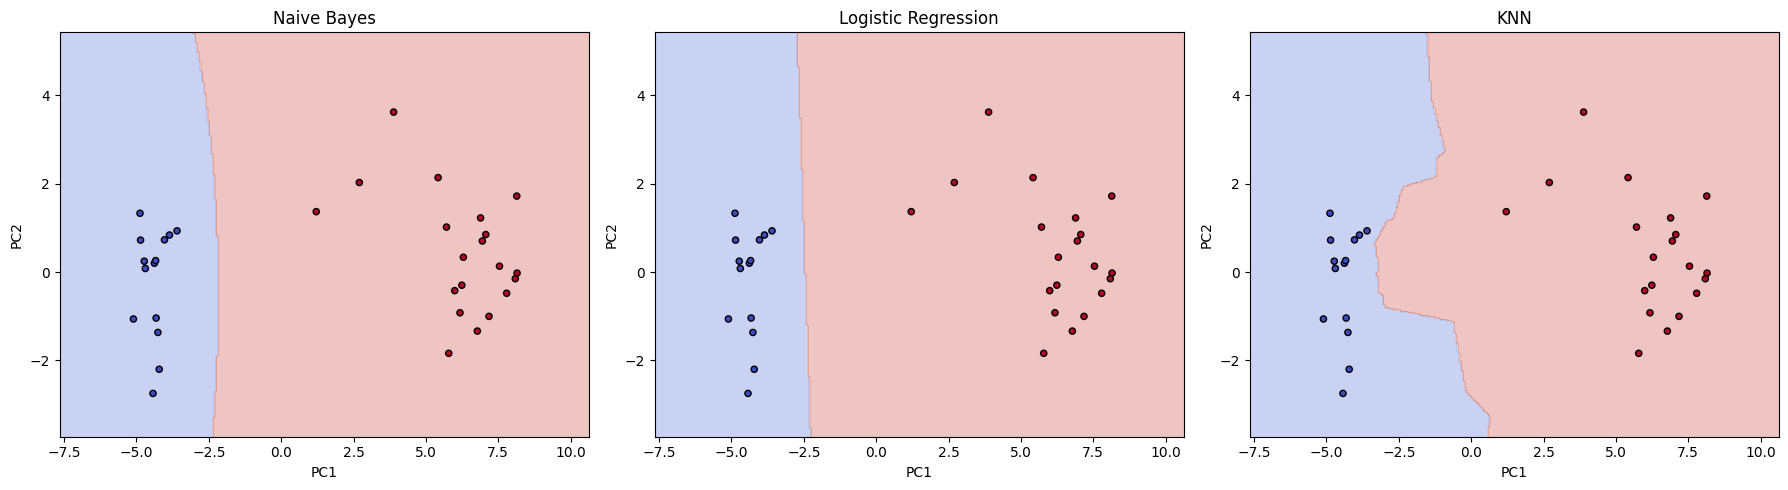

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv("data/marriage.csv")

# Split features and target
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# === Q4.1: Evaluate classifiers on raw data (no PCA) ===
nb_model = GaussianNB().fit(X_train, y_train)
lr_model = LogisticRegression().fit(X_train, y_train)
knn_model = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)

nb_acc = accuracy_score(y_test, nb_model.predict(X_test))
lr_acc = accuracy_score(y_test, lr_model.predict(X_test))
knn_acc = accuracy_score(y_test, knn_model.predict(X_test))

print("Q4.1 Accuracy on raw features:")
print(f"Naive Bayes Accuracy: {nb_acc:.4f}")
print(f"Logistic Regression Accuracy: {lr_acc:.4f}")
print(f"KNN Accuracy: {knn_acc:.4f}")

# === Q4.2: PCA to 2D, retrain classifiers ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Retrain classifiers on 2D PCA data
models = {
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(n_neighbors=3)
}
pca_models = {name: clf.fit(X_train_pca, y_train) for name, clf in models.items()}

# === Plot decision boundaries in 2D PCA space ===
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, clf) in zip(axes, pca_models.items()):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
    ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap="coolwarm", edgecolor='k', s=20)
    ax.set_title(name)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

plt.tight_layout()
plt.show()


4.1  
All three classifiers — Naive Bayes, Logistic Regression, and K-Nearest Neighbors (KNN) — achieved perfect classification performance on the raw features:  
Naive Bayes Accuracy: 1.0000  
Logistic Regression Accuracy: 1.0000  
KNN Accuracy: 1.0000  

This suggests that the dataset is linearly separable in its original high-dimensional space, allowing even simple models like Naive Bayes to perfectly distinguish between the two classes (divorced vs. not divorced). There is very little class overlap or noise, making this a straightforward classification problem.  

4.2  
After applying PCA to reduce the feature space to two dimensions, we retrained all three classifiers and visualized their decision boundaries:  
Naive Bayes produced a smooth, curved boundary based on the Gaussian assumption, cleanly separating the projected points.  
Logistic Regression yielded a nearly linear boundary, consistent with its linear decision rule, which still performed perfectly due to the strong separability of the classes even in 2D.  
KNN created a more jagged, locally adaptive boundary that matched the training data closely. It too was able to correctly classify the points in the test set.   

The PCA projection retained the underlying structure of the data well enough that all three classifiers continued to achieve 100% accuracy even in the reduced space.


5.1  
We are given a set of 7 training messages—3 labeled as Spam and 4 as Non-Spam. According to the problem definition:  
Spam messages are labeled as y = 0   
Non-Spam messages are labeled as y = 1  
The class priors are computed as the relative frequency of each label in the training set:  
$$\mathbb{P}(y = 0) = \frac{3}{7}, \quad \mathbb{P}(y = 1) = \frac{4}{7}$$  

We are also given a vocabulary of 15 words:

V = [thats, not, how, the, force, works, no, dark, side, is, it, a, moon, on, of]

We represent each message as a feature vector of word counts for the words in this vocabulary. Below are the feature vectors for all messages:

Spam messages (y = 0):  
1. "thats not how the force works" → [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
2. no thats the dark side" → [1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]  
3. is it a moon" → [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]  

Non-Spam messages (y = 1):  
1. "it works on the moon"→ [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
2. "thats not it"→ [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
3. "no is not no"→ [0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0]
4. "dark side of the moon"→ [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1]



5.2  
We assume that the words in each message follow a multinomial distribution. The likelihood of a message given its class is:   
$$\mathbb{P}(x \mid y = c) = \frac{n!}{x_1! \cdots x_d!} \prod_{k=1}^{d} \theta_{c,k}^{x_k}$$

To find the MLE estimates for $\theta_{c,k}$ the word probabilities given class $c$ we maximize the log-likelihood:  
$$\ell(\theta) = \sum_{i=1}^{m} \sum_{k=1}^{d} x_k^{(i)} \log \theta_{y^{(i)}, k}$$  
subject to the constraint:  
$$\sum_{k=1}^{d} \theta_{c,k} = 1 \quad \text{for } c = 0, 1$$  
We compute the MLE for each word $\theta_{c,k} = \frac{\text{Count of word } k \text{ in all class } c \text{ messages}}{\text{Total number of words in class } c}$ in class $c$ using: 
$$\theta_{c,k} = \frac{\text{Count of word } k \text{ in all class } c \text{ messages}}{\text{Total number of words in class } c}$$

Let’s now compute these for both classes:   
For Spam class (y = 0):  
We sum the word counts across all 3 spam messages:  
Message 1: [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Message 2: [1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Message 3: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]

Total word counts for spam (sum):  
[2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]  

Total words in spam: $\sum = 15$

So the MLE estimate for each word in spam class is:  
$$\theta_{0,k} = \frac{\text{word count}_k}{15}$$

For Non-Spam class (y = 1):
Messages:  
Message 1: [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
Message 2: [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Message 3: [0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0]
Message 4: [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1]

Total word counts for non-spam (sum):
[1, 3, 0, 2, 0, 1, 2, 1, 1, 1, 2, 0, 2, 1, 1]

Total words in non-spam: $\sum = 19$

So the MLE estimate for each word in non-spam class is:  

$$\theta_{1,k} = \frac{\text{word count}_k}{19}$$

To summarize, the final estimated word probabilities are:

Spam class (y = 0):  
$$\theta_{0} = \left[\frac{2}{15}, \frac{1}{15}, \frac{1}{15}, \frac{2}{15}, \frac{1}{15}, \frac{1}{15}, \frac{1}{15}, \frac{1}{15}, \frac{1}{15}, \frac{1}{15}, \frac{1}{15}, \frac{1}{15}, \frac{1}{15}, 0, 0\right]$$

Non-Spam class (y = 1):  
$$\theta_{1} = \left[\frac{1}{19}, \frac{3}{19}, 0, \frac{2}{19}, 0, \frac{1}{19}, \frac{2}{19}, \frac{1}{19}, \frac{1}{19}, \frac{1}{19}, \frac{2}{19}, 0, \frac{2}{19}, \frac{1}{19}, \frac{1}{19}\right]$$

5.3  
To classify the test message “thats no moon”, we construct a word count vector using the given vocabulary. Only the words “thats”, “no”, and “moon” appear, so the corresponding vector has non-zero entries at those positions. Using the class priors from 5.1 and the maximum likelihood estimates of word probabilities (θ-values) from 5.2, we compute the log-posterior for both spam and non-spam classes. The resulting log-probabilities are approximately -8.2784 for spam and -8.0066 for non-spam. Since the non-spam score is higher, we classify the message as non-spam.  


Question 6  
In the Fair Gaussian Mixture Model with two components $K = 2$, we modify the M-step of the EM algorithm to include the fairness constraints $\pi_1 \geq c$ and $\pi_2 \geq c$ along with the original constraint $\pi_1 + \pi_2 = 1$. In the E-step, we compute the responsibilities $\gamma_{i1}, \gamma_{i2}$ using the standard formula. In the M-step, we maximize the expected complete log-likelihood with respect to the mixture weights $\pi_1, \pi_2$, under the above constraints. This leads to a constrained optimization problem that we solve using Lagrangian multipliers. We define the Lagrangian with multipliers for both the equality and inequality constraints, and apply the KKT conditions (specifically the complementary slackness condition) to identify when the fairness constraint is active. The final update for $\pi_k$ becomes the normalized sum of responsibilities $\gamma_{ik}$, projected onto the feasible region defined by $\pi_1, \pi_2 \geq c$, $\pi_1 + \pi_2 = 1$. If either $\pi_k &lt; c$ occurs in the unconstrained solution, we clip it to $c$ and adjust the other component accordingly to maintain the sum-to-one constraint. This ensures fairness while preserving EM’s convergence behavior.
